<a href="https://colab.research.google.com/github/LiamDuero03/DS-Society-Project/blob/main/Extra ML Material/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Nearest Neighbors (K-NN): The "Neighborhood" Logic
K-NN is a simple, supervised learning algorithm that can be used for both classification and regression. It operates on a very intuitive principle: **"Tell me who your neighbors are, and I'll tell you who you are."**


* **Instance-Based Learning:** It doesn't "learn" a model. Instead, it memorizes the training data and performs a search when a new prediction is needed.
* **The "K" Parameter:** This represents the number of nearest neighbors the model looks at to make a decision.

# K-Nearest Neighbors (K-NN): The "Neighborhood" Logic
**K-NN** is one of the most intuitive algorithms in Machine Learning. It follows a simple rule: *"Tell me who your neighbors are, and I'll tell you who you are."*



## 1. Generating Synthetic Clusters
To demonstrate K-NN, we are using the `make_blobs` function to create **300 samples** grouped into **3 distinct clusters**. This simulates a real-world classification problem, such as grouping customers based on their spending habits and age.

* **n_samples (300):** The total number of data points.
* **centers (3):** The number of categories (classes) we want to predict.
* **cluster_std (1.5):** The "spread" of the data. A higher number makes the clusters overlap, making the classification task more challenging for the algorithm.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 1. Generate clusters with high overlap (increased cluster_std)
X, y = make_blobs(n_samples=300, centers=3, cluster_std=2.5, random_state=42)

# 2. Introduce "Label Noise" (flip 10% of the labels randomly)
rng = np.random.RandomState(42)
noise_subset = rng.choice(len(y), size=int(len(y) * 0.10), replace=False)

# Randomly re-assign labels for the noise subset
y[noise_subset] = rng.randint(0, 3, size=len(noise_subset))



## 2. Feature Scaling & Data Partitioning

Since **K-Nearest Neighbors (K-NN)** calculates the distance between points (typically Euclidean distance), it is **highly sensitive** to the scale of the input features. Without scaling, variables with larger magnitudes will dominate the distance calculation.

### Steps:
* **Standardization:** Transform features to have a mean of 0 and a standard deviation of 1 using `StandardScaler`.
* **Train-Test Split:** Reserve 20% of the data for testing to ensure the model generalizes well to unseen data.

In [8]:
# 2. Scale the data (K-NN is EXTREMELY sensitive to scale because it uses distance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 3. Exploratory Data Visualization

Before training the model, we visualize the feature space to assess the **separability** of the classes. Since we are using scaled data, this scatter plot reveals how distinct the clusters are based on the first two features.

### Key Observations:
* **Cluster Overlap:** Areas where colors mix indicate potential classification errors for K-NN.
* **Feature Distribution:** Helps verify that the `StandardScaler` has centered the data appropriately.
* **Decision Boundaries:** A clearer separation here usually predicts a higher accuracy score.

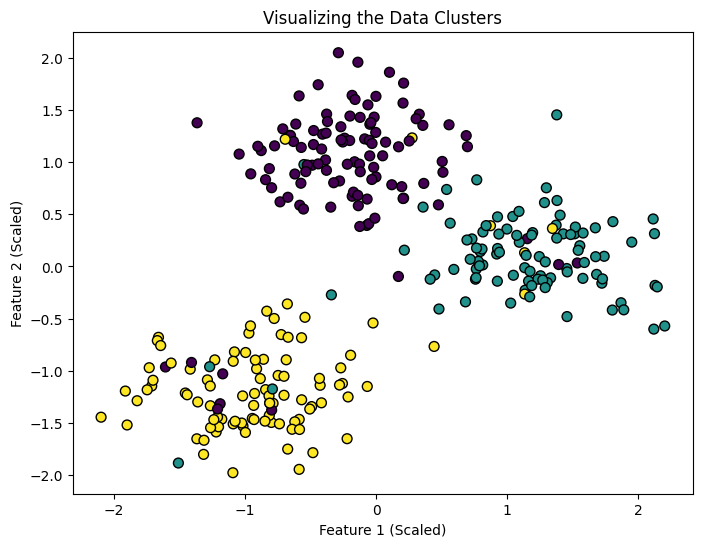

In [9]:
# Visualization of the raw data
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title("Visualizing the Data Clusters")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.show()

## 4. Model Training & Decision Boundary Mapping

We initialize the **K-Nearest Neighbors (K-NN)** classifier and prepare the visualization for its decision boundaries. This involves creating a fine "mesh grid" across the feature space and asking the model to predict the class for every single point on that grid.

### Methodology:
* **Model Initialization:** Setting $k=5$ to balance the bias-variance tradeoff.
* **Mesh Grid Generation:** We define a coordinate matrix (via `meshgrid`) that covers the entire range of our scaled features.
* **Prediction Surface:** By predicting values for the entire grid, we can visualize where the model "decides" one class ends and another begins.

> **Note:** The step size ($h = 0.02$) determines the resolution of the boundary. A smaller $h$ creates a smoother curve but requires more computational power.

In [10]:
# 1. Fit the model with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# 2. Create a mesh grid to plot boundaries
h = .02  # step size in the mesh
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 3. Predict across the entire grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)



## 5. Visualizing Decision Boundaries

The final visualization overlays our original data points on top of the model's **decision regions**. This allows us to see exactly how the K-NN algorithm has partitioned the feature space based on the $k=5$ nearest neighbors.

### Interpretation Guide:
* **Colored Regions:** Represent the "predicted zones." Any new data point falling into these areas would be classified accordingly.
* **Decision Boundaries:** The lines where colors meet. With $k=5$, these boundaries should be relatively smooth; a lower $k$ would make them more jagged (overfitting).
* **Misclassifications:** Points whose color does not match the background region indicate where the model is struggling or where data overlaps.

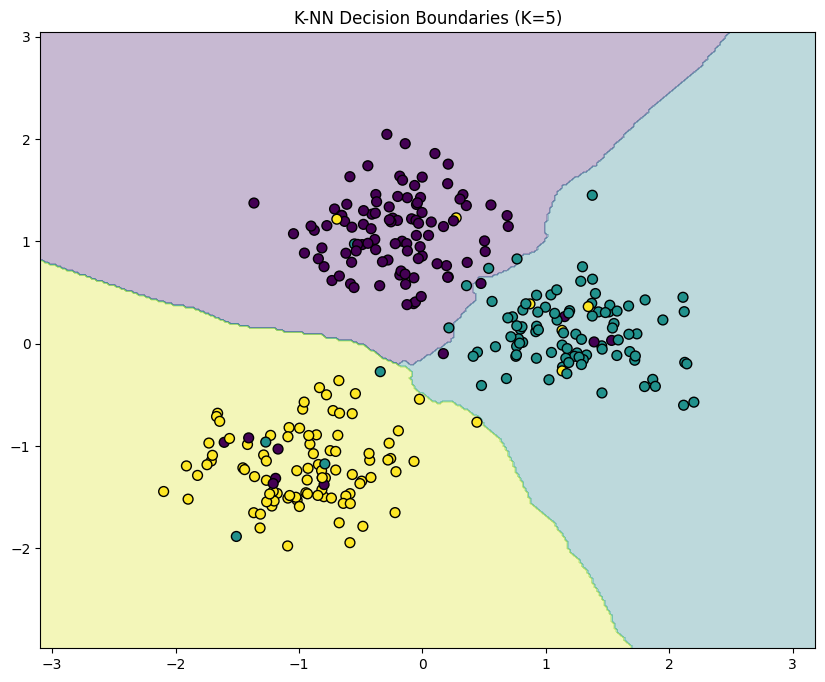

In [11]:
# 4. Plot the results
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title("K-NN Decision Boundaries (K=5)")
plt.show()

## 6. Optimization: Finding the Optimal K-Value

To move beyond an arbitrary choice of $k$, we implement the **Elbow Method**. By iterating through a range of $k$ values and calculating the **Error Rate**, we can identify the point of diminishing returns where the model achieves the best balance between underfitting and overfitting.

### The Logic:
* **Iteration:** We train the model 40 times, incrementing $k$ by 1 each time.
* **Error Tracking:** We calculate the mean difference between our predictions (`pred_i`) and the actual labels (`y_test`).
* **The "Elbow":** On the resulting plot, we look for the "elbow"—the $k$ value where the error rate stabilizes or starts to increase.

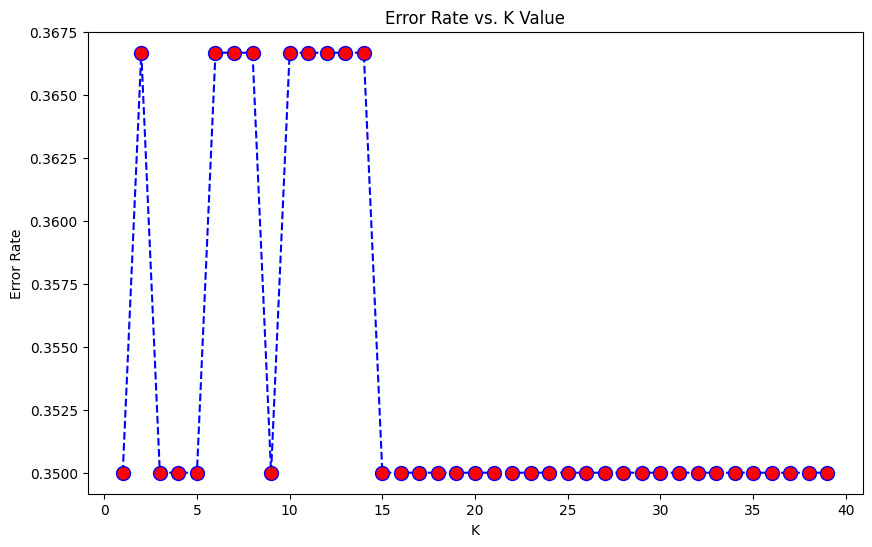

In [12]:
error_rate = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

## 7. Final Model Evaluation: Confusion Matrix

After analyzing the Error Rate plot, we select the optimal $K$ (let's use $K=12$ given the added noise) to train our final model. We then use a **Confusion Matrix** to see the specific breakdown of correct vs. incorrect predictions.

### What to Look For:
* **Diagonal Elements:** High values here indicate correct predictions (True Positives).
* **Off-Diagonal Elements:** These represent "misclassifications." Since we added noise and increased the cluster spread, we expect to see some confusion between overlapping classes.
* **Precision & Recall:** A summary of how well the model handles each specific cluster.

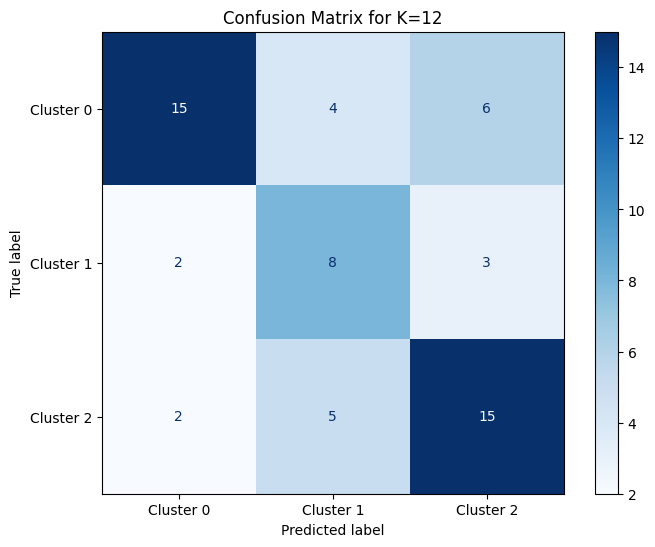

              precision    recall  f1-score   support

           0       0.79      0.60      0.68        25
           1       0.47      0.62      0.53        13
           2       0.62      0.68      0.65        22

    accuracy                           0.63        60
   macro avg       0.63      0.63      0.62        60
weighted avg       0.66      0.63      0.64        60



In [13]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Choose the best K based on the Elbow plot (e.g., K=12)
best_k = 12
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)
final_predictions = final_knn.predict(X_test)

# 2. Generate and Plot the Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title(f'Confusion Matrix for K={best_k}')
plt.show()

# 3. Print the Classification Report for detailed metrics
print(classification_report(y_test, final_predictions))

## 8. Performance Analysis & Interpretation

The classification report reveals the impact of our high-variance data and label noise. We are seeing a significant drop in performance compared to a "clean" dataset, which is expected in realistic or poorly-behaved data environments.

### Key Metrics Breakdown:
* **Precision (Cluster 1: 0.47):** This is quite low. It means that when the model predicts a point belongs to Cluster 1, it is wrong more than half the time. This cluster is likely heavily "invaded" by noise from the other two.
* **Recall (Cluster 0: 0.60):** The model is only catching 60% of the actual members of Cluster 0. Many were likely misclassified into neighboring clusters due to the high standard deviation.
* **F1-Score (The Balance):** Our highest F1-score is **0.68** (Cluster 0), indicating it is the most "stable" cluster, while Cluster 1 is the most problematic (**0.53**).

### Summary:
With an overall accuracy of **63%**, the model is performing better than random guessing (which would be 33% for three classes), but the "noise" we added is successfully preventing the K-NN algorithm from finding clear, reliable boundaries.